<a href="https://colab.research.google.com/github/Felicious/A-Living-Jail/blob/master/Recidivism_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Recidivism**
Team Members: Kaleb Cervantes, Sinclair Chen, Felicia Kuan, Vidya Pingali

**Description**
Data analysis project analyzing the potential bias of Florida's Brown County's criminal recidivism algorithm used for the decisions about releasing criminals for pre-trial, depending on the algorithm's score for the criminal's likelihood of re-offense. 

**Dataset Source**
Broward County Clerk’s Office, Broward County Sherrif's Office, Florida Department of Corrections, ProPublica
https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis

#Importing Libraries

In [0]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing as pre
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier

#Getting and Organizing Data

## Getting the data

This cell gets the url for the dataset

In [0]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-raw.csv'

This usrl is then used to create a dataframe. When observed, we can see that each person takes up 3 rows of the dataframe.

In [0]:
#create dataframe from dataset
data = pd.read_csv(url)

data.head(6)

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0
5,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,18,Risk of Failure to Appear,19.00,3,Low,New,1,0


## Cleaning the Data

### Dropping Columns

We can see that many of the columns are not needed, so we drop specific columns from the dataframe.

In [0]:
#drop certain cells from dataset
drop_columns = ['LastName', 'FirstName', 'MiddleName', #dropped to protect identity
                'AssessmentReason', #same for all entries
                'IsDeleted', #same for all entries
                'IsCompleted', #same for all entries
                'ScaleSet_ID', #redundant info for ScaleSet
                'Scale_ID', #redundant info for Scale
                'DecileScore' #can be calculated with Pandas
               ]

#drops these columns from the dataframe
data = data.drop(drop_columns, axis = 1)

data.head(6)

,Person_ID,AssessmentID,Case_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,DisplayText,RawScore,ScoreText,AssessmentType
0,50844,57167,51950,PRETRIAL,Male,Caucasian,12/05/92,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,Risk of Violence,-2.08,Low,New
1,50844,57167,51950,PRETRIAL,Male,Caucasian,12/05/92,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,Risk of Recidivism,-1.06,Low,New
2,50844,57167,51950,PRETRIAL,Male,Caucasian,12/05/92,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,Risk of Failure to Appear,15.00,Low,New
3,50848,57174,51956,PRETRIAL,Male,Caucasian,09/16/84,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,Risk of Violence,-2.84,Low,New
4,50848,57174,51956,PRETRIAL,Male,Caucasian,09/16/84,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,Risk of Recidivism,-1.50,Low,New
5,50848,57174,51956,PRETRIAL,Male,Caucasian,09/16/84,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,Risk of Failure to Appear,19.00,Low,New


### Having One Row per Arrest

We still see that each person takes up three rows. These rows are identical with two exceptions.

For every grouping of three rows, we have the following pattern for the first difference
1.   Risk of Violence
2.   Risk of Recidivism
3.   Risk of Failure to Appear

The second difference is the numerical score associated with each risk.

Since those are the only differences, It would make since for these to be their own columns

This cell creates paralell arrays of the scores for each person and stores them

In [0]:
#creating arrays
ViolenceScore = []
RecidivismScore = []
FailToAppearScore = []

#filling up arrays with appropriate scores
for tup in data.itertuples():
  if tup[0] % 3 == 0:
    ViolenceScore.append(tup.RawScore)
  elif tup[0] % 3 == 1:
    RecidivismScore.append(tup.RawScore)
  else:
    FailToAppearScore.append(tup.RawScore)

Now the Raw Score and Display Text columns are not needed, so we drop them from the dataframe

In [0]:
data = data.drop(['RawScore', 'DisplayText'], axis = 1)

data.tail(6)

,Person_ID,AssessmentID,Case_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,ScoreText,AssessmentType
60837,65667,79665,72038,Probation,Male,African-American,06/21/64,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,3,Medium with Override Consideration,Low,New
60838,65667,79665,72038,Probation,Male,African-American,06/21/64,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,3,Medium with Override Consideration,High,New
60839,65667,79665,72038,Probation,Male,African-American,06/21/64,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,3,Medium with Override Consideration,High,New
60840,68603,79669,72042,PRETRIAL,Male,Caucasian,02/06/85,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,1,Low,Low,New
60841,68603,79669,72042,PRETRIAL,Male,Caucasian,02/06/85,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,1,Low,Medium,New
60842,68603,79669,72042,PRETRIAL,Male,Caucasian,02/06/85,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,1,Low,Low,New


However, we still have the excess rows left in the dataframe, so we remove them

In [0]:
#drop rows that will become duplicates
drop_indeces = []

size = len(data)
#choose which rows to drop
for i in range (size):
  if (i % 3 != 1):#we did not equals 1 bc these have the description for Recidivism score
    drop_indeces.append(i)
  
#drop rows
data = data.drop(drop_indeces)

data.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,ScoreText,AssessmentType
1,50844,57167,51950,PRETRIAL,Male,Caucasian,12/05/92,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,Low,New
4,50848,57174,51956,PRETRIAL,Male,Caucasian,09/16/84,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,Low,New
7,50855,57181,51963,PRETRIAL,Male,African-American,08/25/94,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,4,High,High,New
10,50850,57176,51958,PRETRIAL,Female,African-American,10/09/94,Risk and Prescreen,English,Pretrial,Jail Inmate,Significant Other,1/1/13 0:00,2,Medium,Medium,New
13,50839,57162,51945,PRETRIAL,Female,African-American,06/29/85,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,Low,New


Now we have one row per arrest. So now we add the scores to the dataframe

In [0]:
data['ViolenceScore'] = ViolenceScore
data['RecidivismScore'] = RecidivismScore
data['FailToAppearScore'] = FailToAppearScore

data.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,ScoreText,AssessmentType,ViolenceScore,RecidivismScore,FailToAppearScore
1,50844,57167,51950,PRETRIAL,Male,Caucasian,12/05/92,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,Low,New,-2.08,-1.06,15.0
4,50848,57174,51956,PRETRIAL,Male,Caucasian,09/16/84,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,Low,New,-2.84,-1.50,19.0
7,50855,57181,51963,PRETRIAL,Male,African-American,08/25/94,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,4,High,High,New,-1.20,0.18,13.0
10,50850,57176,51958,PRETRIAL,Female,African-American,10/09/94,Risk and Prescreen,English,Pretrial,Jail Inmate,Significant Other,1/1/13 0:00,2,Medium,Medium,New,-1.29,-0.53,11.0
13,50839,57162,51945,PRETRIAL,Female,African-American,06/29/85,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,Low,New,-2.90,-1.55,16.0


The indeces in the dataframe are all multiples of 3. So we reset the indeces.

In [0]:
#reset index
data = data.reset_index(drop = True)

data.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,ScoreText,AssessmentType,ViolenceScore,RecidivismScore,FailToAppearScore
0,50844,57167,51950,PRETRIAL,Male,Caucasian,12/05/92,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,Low,New,-2.08,-1.06,15.0
1,50848,57174,51956,PRETRIAL,Male,Caucasian,09/16/84,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,Low,New,-2.84,-1.50,19.0
2,50855,57181,51963,PRETRIAL,Male,African-American,08/25/94,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,4,High,High,New,-1.20,0.18,13.0
3,50850,57176,51958,PRETRIAL,Female,African-American,10/09/94,Risk and Prescreen,English,Pretrial,Jail Inmate,Significant Other,1/1/13 0:00,2,Medium,Medium,New,-1.29,-0.53,11.0
4,50839,57162,51945,PRETRIAL,Female,African-American,06/29/85,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,Low,New,-2.90,-1.55,16.0


### Adding Age

Each person has a Date of Birth and a Screening Date. Since this can be used to calculate age, we decided to make a column

Create array to store ages and calculate them

In [0]:
#create array
Age = []

#calculate ages
for tup in data.itertuples():
  arrest_date = tup.Screening_Date.split()[0] #get string for date
  arrest_date = arrest_date.split('/') #separate into array
  birth_date = tup.DateOfBirth.split('/') #separate into array
  arrest_age = 100 + int(arrest_date[2]) - int(birth_date[2]) #calculate age based on year
  if (int(birth_date[0]) < int(arrest_date[0])): #correct if birth month has not been reached
    arrest_age -= 1
  elif (int(birth_date[1]) < int(arrest_date[1])): #correct if birthday has not been reached
    arrest_age -= 1
  Age.append(arrest_age)

Add Age to the dataframe

In [0]:
#add age column
data['Age'] = Age

data = data.drop(['DateOfBirth', 'Screening_Date'], axis = 1)

data.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,RecSupervisionLevel,RecSupervisionLevelText,ScoreText,AssessmentType,ViolenceScore,RecidivismScore,FailToAppearScore,Age
0,50844,57167,51950,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1,Low,Low,New,-2.08,-1.06,15.0,21
1,50848,57174,51956,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,1,Low,Low,New,-2.84,-1.50,19.0,29
2,50855,57181,51963,PRETRIAL,Male,African-American,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,4,High,High,New,-1.20,0.18,13.0,19
3,50850,57176,51958,PRETRIAL,Female,African-American,Risk and Prescreen,English,Pretrial,Jail Inmate,Significant Other,2,Medium,Medium,New,-1.29,-0.53,11.0,19
4,50839,57162,51945,PRETRIAL,Female,African-American,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1,Low,Low,New,-2.90,-1.55,16.0,28


### Fixing Ethnic Code Text

For Ethnic Code, we noticed there is an "African-American" category and an "African-Am" category, which is probably just a difference in inputting among different jails. Therefore, we changed any entries labeled as "African-Am" to "African-American" so the label would be consistent. There is also an "Asian" category, as well as an "Oriental" category and we did the same to group them together. So we were able to delete two Ethnic Code categories (African-Am and Oriental) without deleting the entries. 




In [0]:
Ethnic_Code_Text = data.Ethnic_Code_Text.values

data.Ethnic_Code_Text.value_counts()

African-American    9006
Caucasian           7261
Hispanic            2914
Other                864
Asian                108
Native American       73
Arabic                25
African-Am            17
Oriental              13
Name: Ethnic_Code_Text, dtype: int64

In [0]:
for i in range(len(Ethnic_Code_Text)):
  if (Ethnic_Code_Text[i] == 'African-Am'):
    Ethnic_Code_Text[i] = 'African-American'
  elif (Ethnic_Code_Text[i] == 'Oriental'):
    Ethnic_Code_Text[i] = 'Asian'
    
data.Ethnic_Code_Text.value_counts()
    

African-American    9023
Caucasian           7261
Hispanic            2914
Other                864
Asian                121
Native American       73
Arabic                25
Name: Ethnic_Code_Text, dtype: int64

In [0]:
data['Ethnic_Code_Text'] = Ethnic_Code_Text

data.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,RecSupervisionLevel,RecSupervisionLevelText,ScoreText,AssessmentType,ViolenceScore,RecidivismScore,FailToAppearScore,Age
0,50844,57167,51950,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1,Low,Low,New,-2.08,-1.06,15.0,21
1,50848,57174,51956,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,1,Low,Low,New,-2.84,-1.50,19.0,29
2,50855,57181,51963,PRETRIAL,Male,African-American,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,4,High,High,New,-1.20,0.18,13.0,19
3,50850,57176,51958,PRETRIAL,Female,African-American,Risk and Prescreen,English,Pretrial,Jail Inmate,Significant Other,2,Medium,Medium,New,-1.29,-0.53,11.0,19
4,50839,57162,51945,PRETRIAL,Female,African-American,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1,Low,Low,New,-2.90,-1.55,16.0,28


## Overview of the Data

Basic statistics on the data

In [0]:
data.describe()

,Person_ID,AssessmentID,Case_ID,RecSupervisionLevel,ViolenceScore,RecidivismScore,FailToAppearScore,Age
count,20281.000000,20281.000000,20281.000000,20281.000000,20281.000000,20281.000000,20281.000000,20281.000000
mean,53683.206154,68061.029190,60209.128149,1.630048,-2.522486,-0.770592,18.537449,33.445984
std,14363.884602,7320.328544,9638.660076,0.944235,0.891932,0.847866,5.495685,12.189470
min,656.000000,649.000000,350.000000,1.000000,-4.790000,-3.210000,11.000000,15.000000
25%,52039.000000,62582.000000,56021.000000,1.000000,-3.180000,-1.380000,14.000000,24.000000
50%,57321.000000,68229.000000,61261.000000,1.000000,-2.530000,-0.760000,17.000000,30.000000
75%,62748.000000,73870.000000,66554.000000,2.000000,-1.900000,-0.150000,22.000000,42.000000
max,68608.000000,79678.000000,72045.000000,4.000000,1.520000,2.360000,51.000000,94.000000


More information on the data

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20281 entries, 0 to 20280
Data columns (total 19 columns):
Person_ID                  20281 non-null int64
AssessmentID               20281 non-null int64
Case_ID                    20281 non-null int64
Agency_Text                20281 non-null object
Sex_Code_Text              20281 non-null object
Ethnic_Code_Text           20281 non-null object
ScaleSet                   20281 non-null object
Language                   20281 non-null object
LegalStatus                20281 non-null object
CustodyStatus              20281 non-null object
MaritalStatus              20281 non-null object
RecSupervisionLevel        20281 non-null int64
RecSupervisionLevelText    20281 non-null object
ScoreText                  20245 non-null object
AssessmentType             20281 non-null object
ViolenceScore              20281 non-null float64
RecidivismScore            20281 non-null float64
FailToAppearScore          20281 non-null float64
Age       

# Splitting the Data

For Logistical Regression, we need to separate the data into Training Data and Test Data

We were advised to use 80% of the data for training and 20% of the data for testing. So in this cell we take a random sample for the Test Data and use everything else for Training Data.

In [0]:
#split up training and test data
test_data = data.sample(frac = 0.2, random_state = 96000)

training_data = data.drop(test_data.index)

We look at the Data to gain some information on the nature of the entries

In [0]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4056 entries, 7160 to 16817
Data columns (total 19 columns):
Person_ID                  4056 non-null int64
AssessmentID               4056 non-null int64
Case_ID                    4056 non-null int64
Agency_Text                4056 non-null object
Sex_Code_Text              4056 non-null object
Ethnic_Code_Text           4056 non-null object
ScaleSet                   4056 non-null object
Language                   4056 non-null object
LegalStatus                4056 non-null object
CustodyStatus              4056 non-null object
MaritalStatus              4056 non-null object
RecSupervisionLevel        4056 non-null int64
RecSupervisionLevelText    4056 non-null object
ScoreText                  4048 non-null object
AssessmentType             4056 non-null object
ViolenceScore              4056 non-null float64
RecidivismScore            4056 non-null float64
FailToAppearScore          4056 non-null float64
Age                       

In [0]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16225 entries, 0 to 20279
Data columns (total 19 columns):
Person_ID                  16225 non-null int64
AssessmentID               16225 non-null int64
Case_ID                    16225 non-null int64
Agency_Text                16225 non-null object
Sex_Code_Text              16225 non-null object
Ethnic_Code_Text           16225 non-null object
ScaleSet                   16225 non-null object
Language                   16225 non-null object
LegalStatus                16225 non-null object
CustodyStatus              16225 non-null object
MaritalStatus              16225 non-null object
RecSupervisionLevel        16225 non-null int64
RecSupervisionLevelText    16225 non-null object
ScoreText                  16197 non-null object
AssessmentType             16225 non-null object
ViolenceScore              16225 non-null float64
RecidivismScore            16225 non-null float64
FailToAppearScore          16225 non-null float64
Age       

# Fitting the Data

## Encoding the Data

From looking at the info for each data frame, we can see that many of the columns do not contain numerical values. This will cause issues when it comes to using the data for logistical regression. Because of this, we encode many of the columns.

### Creating Label Encoders
Label Encoders can be made as individidual vairables. However, since we have to encode so many columns we made a dictionary of Label Encoders. More specifically, we use the column name to access the Label Encoder for that attribute.

Gather column names for columns we need to encode

In [0]:
text_col = ['Agency_Text',
            'Sex_Code_Text',
            'Ethnic_Code_Text',
            'ScaleSet',
            'LegalStatus',
            'CustodyStatus',
            'MaritalStatus',
            'AssessmentType',
            'Language'
           ]

Now that we know the text columns we are encoding we can now make the Label Encoders for those attributes.

In [0]:
le_dict = {}

#insert key and label encoder
for col in text_col:
  le_dict[col] = pre.LabelEncoder()

Due to how SKLearn works, we cannot have what we are estimating be a continuous type, such as `float64`.

Since RecidivismScore is of type, `float64`,  we have to encode that attribute as well

In [0]:
le_dict['RecidivismScore'] = pre.LabelEncoder()

le_dict['ScoreText'] = pre.LabelEncoder()

### Encoding

There is some information in the Test Data that is useful for observing the Data, but will not be used for fitting or estimating.

In [0]:
X_drop = ['Person_ID', #ID not needed
          'AssessmentID', #ID not needed
          'Case_ID', #ID not needed
          'RecidivismScore', #this will be our dependent variable and thus cannot be one of the independent variables
          'RecSupervisionLevelText', #There is already a numerical value for this in the Training Data
          'ScoreText' #is a dependant variable
         ]

Create `X` and `y` for Logistic regression

In [0]:
X = training_data.drop(X_drop, 1)

X.head()

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,RecSupervisionLevel,AssessmentType,ViolenceScore,FailToAppearScore,Age
0,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1,New,-2.08,15.0,21
1,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,1,New,-2.84,19.0,29
2,PRETRIAL,Male,African-American,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,4,New,-1.20,13.0,19
3,PRETRIAL,Female,African-American,Risk and Prescreen,English,Pretrial,Jail Inmate,Significant Other,2,New,-1.29,11.0,19
4,PRETRIAL,Female,African-American,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,1,New,-2.90,16.0,28


In [0]:
y = training_data.RecidivismScore

y.head()

0   -1.06
1   -1.50
2    0.18
3   -0.53
4   -1.55
Name: RecidivismScore, dtype: float64

In [0]:
y_text = training_data['ScoreText']

y_text.head()

0       Low
1       Low
2      High
3    Medium
4       Low
Name: ScoreText, dtype: object

Now we encode `X` and `y`.

`fit_transform()` is used here because it both fits the data and returns the transformed version. This will only be used for the Training Data.

In [0]:
for col in text_col:
  X[col] = le_dict[col].fit_transform(X[col])
  

y = le_dict['RecidivismScore'].fit_transform(y)

y_text = le_dict['ScoreText'].fit_transform(y_text)

In [0]:
X.head()

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,RecSupervisionLevel,AssessmentType,ViolenceScore,FailToAppearScore,Age
0,2,1,3,1,0,5,0,4,1,1,-2.08,15.0,21
1,2,1,3,1,0,5,0,1,1,1,-2.84,19.0,29
2,2,1,0,1,0,5,0,4,4,1,-1.20,13.0,19
3,2,0,0,1,0,5,0,3,2,1,-1.29,11.0,19
4,2,0,0,1,0,5,0,4,1,1,-2.90,16.0,28


In [0]:
print y[0:5]

print y_text[0:5]

[197 153 321 250 148]
[2 2 1 3 2]


## Fitting

Now that we have the encoding, we can now fit the data so it can be used for estimating.

This Cell takes a while since it has to fit a large amount of data.

In [0]:
lr = LogisticRegression()

lr.fit(X, y)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
knn = KNeighborsClassifier(n_neighbors = 5)

knn.fit(X, y_text)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

# Predicting

Encoding the Test Data

In [0]:
#drop doesn't change original. I'm removing Recidivism score + other stuff. -S
X_test = test_data.drop(X_drop, 1)

#transform test data using the fit from the training data
for col in text_col:
  X_test[col] = le_dict[col].transform(X_test[col])

## Getting Expected Values

Now that all the data is fit, we can now get the estimated values for Recidivism Score

Estimate for Training Data

In [0]:
#array of estimated predicted values
RecidivismEst = lr.predict(X)
RecidivismEst = le_dict['RecidivismScore'].inverse_transform(RecidivismEst)

Estimate for Test Data

In [0]:
#predict the recidivism scores
RecidivismEstTest = lr.predict(X_test)
RecidivismEstTest = le_dict['RecidivismScore'].inverse_transform(RecidivismEstTest)

## Checking MSE

Now that we have the values, we can now see how much error there was, and the MSE (mean squared error) represents how much the predicted value strays from the actual value

Training MSE

In [0]:
print mean_squared_error(training_data.RecidivismScore, RecidivismEst)

0.13375605546995378


Test MSE

In [0]:
print mean_squared_error(test_data.RecidivismScore, RecidivismEstTest)

0.13520751972386585


# Adding Estimates to Dataframes

Add estimates to Training Data


In [0]:
training_data['RecidivismEst'] = RecidivismEst

training_data['ScoreTextEst'] = le_dict['ScoreText'].inverse_transform(knn.predict(X))

training_data.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,Language,LegalStatus,CustodyStatus,...,RecSupervisionLevel,RecSupervisionLevelText,ScoreText,AssessmentType,ViolenceScore,RecidivismScore,FailToAppearScore,Age,RecidivismEst,ScoreTextEst
0,50844,57167,51950,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,...,1,Low,Low,New,-2.08,-1.06,15.0,21,-0.95,Low
1,50848,57174,51956,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,...,1,Low,Low,New,-2.84,-1.50,19.0,29,-1.14,Low
2,50855,57181,51963,PRETRIAL,Male,African-American,Risk and Prescreen,English,Pretrial,Jail Inmate,...,4,High,High,New,-1.20,0.18,13.0,19,0.28,High
3,50850,57176,51958,PRETRIAL,Female,African-American,Risk and Prescreen,English,Pretrial,Jail Inmate,...,2,Medium,Medium,New,-1.29,-0.53,11.0,19,-0.18,Medium
4,50839,57162,51945,PRETRIAL,Female,African-American,Risk and Prescreen,English,Pretrial,Jail Inmate,...,1,Low,Low,New,-2.90,-1.55,16.0,28,-1.45,Low


Add estimates to Test Data

In [0]:
test_data['RecidivismEst'] = RecidivismEstTest

test_data['ScoreTextEst'] = le_dict['ScoreText'].inverse_transform(knn.predict(X_test))

test_data.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,Language,LegalStatus,CustodyStatus,...,RecSupervisionLevel,RecSupervisionLevelText,ScoreText,AssessmentType,ViolenceScore,RecidivismScore,FailToAppearScore,Age,RecidivismEst,ScoreTextEst
7160,21368,65072,20522,PRETRIAL,Male,African-American,Risk and Prescreen,English,Pretrial,Jail Inmate,...,2,Medium,Medium,Copy,-2.99,0.03,21.0,50,0.02,Medium
12597,61838,71072,64437,PRETRIAL,Male,African-American,Risk and Prescreen,English,Pretrial,Jail Inmate,...,1,Low,Low,New,-3.10,-1.75,20.0,29,-1.10,Low
4214,47819,61834,48429,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Pretrial Defendant,...,2,Medium,Medium,Copy,-1.69,-0.08,18.0,26,-0.09,Medium
5055,55114,62712,56903,PRETRIAL,Male,African-American,Risk and Prescreen,English,Pretrial,Jail Inmate,...,1,Low,Medium,New,-1.90,-0.43,13.0,20,-0.81,Low
18665,67147,77881,70490,Probation,Male,African-American,Risk and Prescreen,English,Post Sentence,Probation,...,1,Low,Low,New,-3.82,-1.76,20.0,57,-1.86,Low


## Visualization of Dataset

After we have successfully cleaned and analyzed our dataset, we will plot our dataset to get and idea of what sort of data we have, and attempt to find the columns that will contain bias.

**Correlation between Age and Violence on Recidivism Score**

---

D E S C R I P T I O N

Below we have a graph that plots Violence score on the x-axis and Age on the y-axis. The points are color-coded based on the range of the Recidivism Score of the criminal, and they are placed on the graph according to their age and violence score.

Note that the minimum y value of the graph seems to be 16, because any younger criminals would just be sent to juvie.


I N T E R P R E T A T I O N

As the majority of the points are blue (indicating a low recidivism score) as the criminal is older, we can conclude that younger criminals are more likely to have a higher recidivism score (colored red). This is because the majority of high recidivism scores are plotted on the lower right region of the graph, where the young criminals (aged 16 - 25) are.

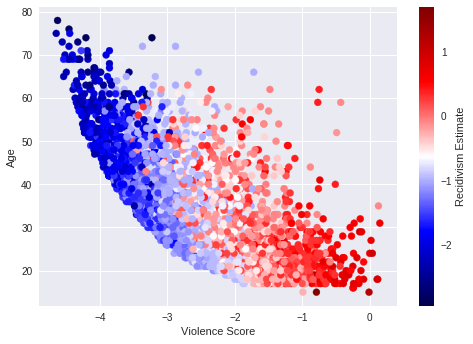

In [0]:
plt.scatter(x = test_data.ViolenceScore, y = test_data.Age, c = test_data.RecidivismEst, cmap='seismic')
plt.xlabel('Violence Score')
plt.ylabel('Age')
cbar = plt.colorbar()
cbar.set_label('Recidivism Estimate')

**Correlation between Sex and Violence on Recidivism Score**

---

D E S C R I P T I O N

Below we have a graph that plots Violence score on the x-axis and Recidivism score on the y-axis. The points are color-coded based on the Sex of the criminal, with dark red representing the males and blue for female. 

I N T E R P R E T A T I O N

The majority of the inmates are male, so there is more red on the graph than blue, but at a glance, it seems that many of the blue points are clustered in the lower and middle parts of the graph, meaning that the majority of the female criminals are given a lower violence score and are consequently given a lower recidivism score, compared to the high scoring red points on the upper right. 


Text(0,0.5,'RecidivismScore')

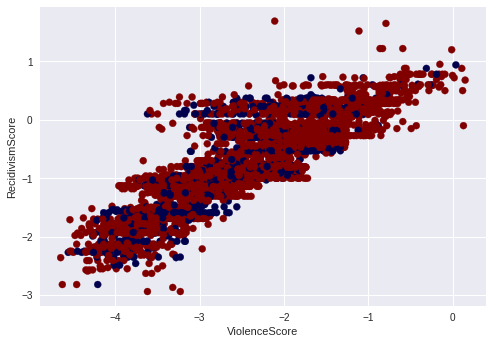

In [0]:
plt.scatter(x = test_data.ViolenceScore, y = test_data.RecidivismEst, c = X_test.Sex_Code_Text, cmap='seismic')
plt.xlabel('ViolenceScore')
plt.ylabel('RecidivismScore')

**Correlation between Violence and Failure to Appear on Recidivism Score**
_____

D E S C R I P T I O N

Below we have a graph that plots Violence score on the x-axis and the Failure to Appear score on the y-axis. The points are color-coded based on the the recidivism score so blue represents a lower score while red represents a higher score.

I N T E R P R E T A T I O N

The blue dots (low recidivism score) are mainly in the bottom left corner, which makes sense as these people have a lower violence score and have a lower Failure to Appear score, which meant they showed up, so they have a lower recidivism score. The people with a higher recidivism score tend to have a high violence score, but surprisingly, not all of them have a high "Failure to Appear Score." There are many inmates with a high recidivism score that have a lower "Failure to Appear" score than inmates with a lower recidivism, showing that the Violence score seems to have a greater effect on recidivism than Failure to Appear. 

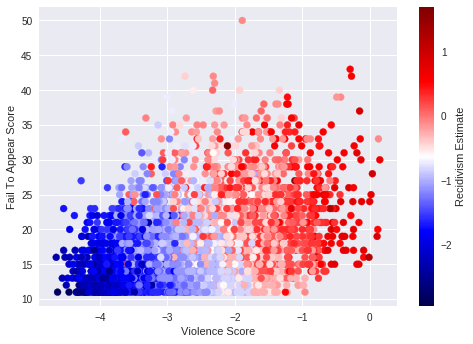

In [0]:
plt.scatter(x = test_data.ViolenceScore, y = test_data.FailToAppearScore, c = test_data.RecidivismEst, cmap='seismic')
plt.xlabel('Violence Score')
plt.ylabel('Fail To Appear Score')
cbar = plt.colorbar()
cbar.set_label('Recidivism Estimate')

**Correlation between Supervision Level and Failure to Appear on Recidivism Score**
______


D E S C R I P T I O N
​

Below we have a graph that plots Supervision Level score on the x-axis and the Failure to Appear score on the y-axis. The points are color-coded based on the the recidivism score so blue represents a lower score while red represents a higher score. There are 4 types of Supervision Level: Medium, Low, Medium with Override Consideration, and High.
​

I N T E R P R E T A T I O N

The blue dots (low recidivism score) are all in the Low Supervision column, which makes sense as these inmates probably do not need as much supervision and are there for petty crimes. They also have the lowest "Failure to Appear" score. The people with a higher recidivism score tend to have more supervision. However, within the different shades of red (high recidivism score), there is no correlation between Supervision Level and Failure to Appear Score since the shades alternate (especially in the Medium Supervision column). The High Supervision column has the highest recidivism score of course.

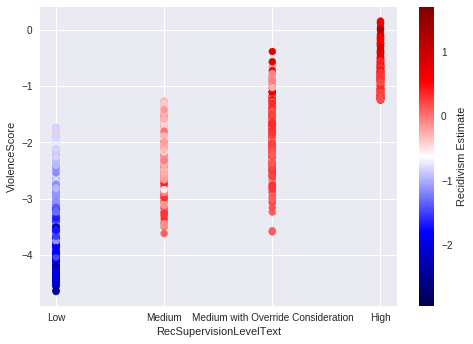

In [0]:
#done so graph is in order
test_data = test_data.sort_values(by = ['RecSupervisionLevel'])

plt.scatter(x = test_data.RecSupervisionLevelText, y = test_data.ViolenceScore, c = test_data.RecidivismEst, cmap='seismic')
plt.xlabel('RecSupervisionLevelText')
plt.ylabel('ViolenceScore')
cbar = plt.colorbar()
cbar.set_label('Recidivism Estimate')

**Correlation between Age and Failure to Appear on Recidivism Score**

---

D E S C R I P T I O N

Below we have a graph that plots Failure to Appear score on the x-axis and Age on the y-axis. The points are color-coded based on the range of the Recidivism Score of the criminall with blue dots representing a lower score and red representing a higher score.


I N T E R P R E T A T I O N

The majority of the blue dots (lower recidivism score) seem to be inmates with a lower Failure to Appear Score and older inmates (average around 50 years old). Inmates with a higher recidivism score (red dots) have a higher failure to appear score and are typically younger (average around 30 years old). Younger inmates seem to have a higher recidivism score and those with a higher Failure to Appear score have are more likely to have a higher recidivism score as well.

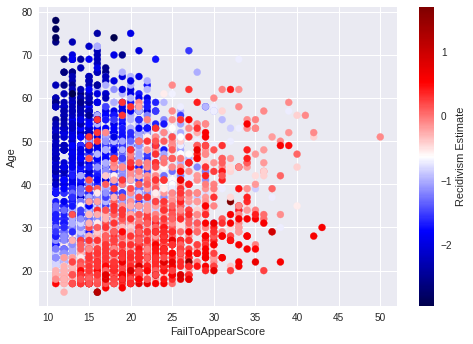

In [0]:
plt.scatter(x = test_data.FailToAppearScore, y = test_data.Age, c = test_data.RecidivismEst, cmap='seismic')
plt.xlabel('FailToAppearScore')
plt.ylabel('Age')
cbar = plt.colorbar()
cbar.set_label('Recidivism Estimate')

Text(0,0.5,'RecidivismEst')

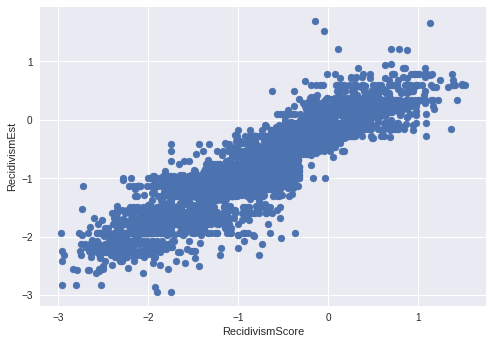

In [0]:
plt.scatter(x = test_data.RecidivismScore, y = test_data.RecidivismEst)
plt.xlabel('RecidivismScore')
plt.ylabel('RecidivismEst')

## Assumptions

Based on our above visualizations, we are assuming that the following columns are the columns that create bias:


1.   Sex
2.   Race
1.   Assessment_Type (repeated incrimination)







# Analysis 

Apparently our dataset is biased towards certain people, perhaps our next step is to show *how* the results are biased.

In our analysis, we assume that a **low** recidivism score is **good**, because it assumes the criminal is unlikely to be jailed again, and a **high** recidivism score is **bad** because it indicates the criminal is more likely to be jailed again.

Using both the Scikitlearn and Themis-ML Logistical Regression function, we are able to compare and observe which function, based on the same dataset, concludes a certain group of people is deemed by the algorithm to have a higher chance of recidivism. As for the **metric** that will help us determine the amount of bias present in the result, we decided to calculate the **mean difference** between the advantaged and disadvantaged groups.


In [0]:
!pip install -q themis-ml

    100% |████████████████████████████████| 9.0MB 1.7MB/s 


In [0]:
from themis_ml.metrics import mean_difference
from themis_ml.linear_model import LinearACFClassifier
from themis_ml.meta_estimators import FairnessAwareMetaEstimator
from sklearn.base import BaseEstimator

## Dropping Language

The reason why we decided to drop the Languages column in our analysis because after we took a look at the dataset we realized that on average, there were only about 16-17 Spanish speakers in the training data. 

To accurately estimate whether there is bias in our dataset based on the language of which the assessment was conducted, we need at least 30 samples. So the best course of action was to completely omit the consideration of language in our analysis.

For this reason, we may also drop other data that has an insufficient number of samples to create a more accurate bias analysis of the dataset.

## Protected classes

Protected classes: when we’re calculating mean differences using the Themis-ML package, we have to identify what we initially believed to be the advantaged group (labeled 0) and the disadvantaged group (labeled as 1) 

The mean difference function returns the average for the advantaged group subtracted by the disadvantaged group. 

So for example, if our mean difference is a negative value, then the bias is in favor of the disadvantaged group.

**Mean diff = p(y+ | s0) - p(y+ |s1)**

This following section of code encodes our data in order to prepare the appropriate columns in our bias analysis. 

In [0]:
y_protected = np.array([int(val <= 0) for val in training_data.RecidivismScore])
y_protected_test = np.array([int(val <= 0) for val in test_data.RecidivismScore])
y_protected_skl = np.array([int(val <= 0) for val in test_data.RecidivismEst])

## Encoding Training & Testing Data
To check bias, we have to have a binary array called `s` in which someone in an advantaged group has a value of `0` and someone in a disadvantaged group has a value of `1`.

To take care of this, we made a function called `make_s` which takes in the parameters

*   `df` which is the dataframe we are getting the values from
*   `col` which is the column name
*   `a` which is the advantaged group name or an array of advantaged group names

`s` is the encoded values


In [0]:
def make_s(df, col, a):
  if (type(a) == str):
    return np.array([int(val != a) for val in df[col]])
        
  elif (type(a) == list):
    return np.array([int(a.count(val) == 0) for val in df[col]])
  
  else:
    return -1

Here, we are encoding the training and testing data we will use while checking for bias based on sex. Initially, we guessed the advantaged group (the group that will have a higher recidivism score) is male, so we assigned them to the 0 group and the females to 1.

In [0]:
col_sex = 'Sex_Code_Text'
a_sex = 'Male'

s_sex = make_s(training_data, col_sex, a_sex)
    
s_sex_test = make_s(test_data, col_sex, a_sex)

When checking for bias of our dataset for race, we guessed initially that the advantaged group was Caucasian, and the disadvantaged group was all of the minority groups. Due to how the Themis-ML function is written, it can only check the bias of two groups at a time. Therefore, the following code is to filter the Caucasians into group 0 and all other minority groups into group 1.

In [0]:
col_race = 'Ethnic_Code_Text'
a_race = 'Caucasian'

s_race = make_s(training_data, col_race, a_race)
    
s_race_test = make_s(test_data, col_race, a_race)

Now we're checking whether the algorithm is biased towards returning inmates. We encoded the advantaged group to be first-time inmates and the disadvantaged group to be returning inmates. Therefore, our initial guess is that the algorithm is more likely to assign first-time offenders a higher residivism score. 

In [0]:
col_lang = 'Language'
a_lang = 'English'

s_lang = make_s(training_data, col_lang, a_lang)
    
s_lang_test = make_s(test_data, col_lang, a_lang)

On a high level, this is a function that obtains the p-value of a t-distribution when given a confidence interval as a parameter. 


In [0]:
from scipy.stats import t

def p_val(y, s):
  meandiff, lower, upper = mean_difference(y, s)
  em = (upper - lower) / 2
  df = len(s) - 2
  t_val = t.ppf(0.975, df)
  numerator = meandiff
  demoninator = em / t_val
  T_stat = numerator / demoninator
  return t.sf(np.abs(T_stat), df)*2

## Performing LogReg

Logistical Regression Analysis using Themis-ML function (and Scikitlearn?)

When interpreting our results, note that we have a p-value and various confidence intervals involved with the bias of the dataset and predictions.

When the p-value is extremely low, this means that there is an impossibly low probability that there's no bias, so when the **p-value is very low, there's definitely bias involved in the column**.

### Bias Based on Sex


In [0]:
X_sex = X.drop(['Sex_Code_Text'], axis = 1)
lr_sex = LinearACFClassifier()
lr_sex.fit(X_sex, y_protected, s_sex)

pred_y_sex = lr_sex.predict(X_sex, s_sex)

X_sex_test = X_test.drop(['Sex_Code_Text'], axis = 1)

pred_y_sex_test = lr_sex.predict(X_sex_test, s_sex_test)

print('training mean diff for sex = %f with 95%% CI [%f, %f]' %mean_difference(y_protected, s_sex))
print('with p-value %f for no bias\n' %(p_val(y_protected, s_sex)))

print('test mean diff for sex w/ actual score = %f with 95%% CI [%f, %f]' %mean_difference(y_protected_test, s_sex_test))
print('test mean diff for sex w/ estimated score w/ themis = %f with 95%% CI [%f, %f]' %mean_difference(pred_y_sex_test, s_sex_test))
print('test mean diff for sex w/ estimated score w/ skl = %f with 95%% CI [%f, %f]' %mean_difference(y_protected_skl, s_sex_test))


training mean diff for sex = -0.112262 with 95% CI [-0.126910, -0.097614]
with p-value 0.000000 for no bias

test mean diff for sex w/ actual score = -0.106834 with 95% CI [-0.136154, -0.077515]
test mean diff for sex w/ estimated score w/ themis = 0.028472 with 95% CI [-0.000946, 0.057889]
test mean diff for sex w/ estimated score w/ skl = -0.016550 with 95% CI [-0.044253, 0.011154]


**Results**

When checking for bias of our dataset for sex, we guessed initially that the advantaged group was male. The following are the results, with the the first representing the bias based on sex of the original dataset, and the last representing the bias-adjusted result using Themis-ML:
 


1.   test mean diff for sex w/ actual score = -0.106834 with 95% CI [-0.136154, -0.077515]
2.  test mean diff for sex w/ estimated score w/ themis = -0.061653 with 95% CI [-0.091022, -0.032283]
1.   test mean diff for sex w/ estimated score w/ skl = -0.016550 with 95% CI [-0.044253, 0.011154]

**Interpreting mean differences**
Based on our results, because the first mean difference of the original dataset was negative, we know that the original dataset was biased towards the disadvantaged group (female). Therefore, the **females had** a (on average) **lower recidivism score** compared to the males, because the algorithm was **more likely to assign a higher recidivism score to males**. As for our prediction model, we observe that the themis prediction is more biased towards females than the Scikit Learn model.

Also, the p-value was 0, meaning there was** definitely bias** based on sex. 


### Bias Based on Race

The following is the most controversial part of our criminal recidivism project. Given the heated controversies we have today over the bias of police profiling and arrests against people of color, we were particularly interested in our project to observe the amount of bias the dataset contains comparing the the various racial groups together.    

Additionally, based on the way the Logistical Regession function of Themis-ML is written, we can only check the bias of two groups at a time. In the following subsections, although algorithmically we can only check the bias of two groups at a time, we manually grouped the racial groups in the "Encoding" section into two larger groups (ie. Caucasians in group 0, all other minorities in group 1)

**White vs Minority groups**

When checking for bias of our dataset for race, we guessed initially that the advantaged group was Caucasian, and the disadvantaged group was all of the minority groups. Due to how the Themis-ML function is written, it can only check the bias of two groups at a time. Therefore, the following code is to filter the Caucasians into group 0 and all other minority groups into group 1.


In [0]:
X_race = X.drop(['Ethnic_Code_Text'], axis = 1)
lr_race = LinearACFClassifier()
lr_race.fit(X_race, y_protected, s_race)

pred_y_race = lr_race.predict(X_race, s_race)

X_race_test = X_test.drop(['Ethnic_Code_Text'], axis = 1)

pred_y_race_test = lr_race.predict(X_race_test, s_race_test)

print('training mean diff for race = %f with 95%% CI [%f, %f]' %mean_difference(y_protected, s_race))
print('with p-value %f for no bias\n' %(p_val(y_protected, s_race)))

print('test mean diff for race w/ actual score = %f with 95%% CI [%f, %f]' %mean_difference(y_protected_test, s_race_test))
print('test mean diff for race w/ estimated score = %f with 95%% CI [%f, %f]' %mean_difference(pred_y_race_test, s_race_test))
print('test mean diff for race w/ estimated score w/ skl = %f with 95%% CI [%f, %f]' %mean_difference(y_protected_skl, s_race_test))


training mean diff for race = 0.117668 with 95% CI [0.105041, 0.130296]
with p-value 0.000000 for no bias

test mean diff for race w/ actual score = 0.147975 with 95% CI [0.123182, 0.172767]
test mean diff for race w/ estimated score = 0.009770 with 95% CI [-0.015225, 0.034764]
test mean diff for race w/ estimated score w/ skl = 0.128254 with 95% CI [0.104911, 0.151596]


The following are the results, with the the first representing the bias based on race of the original dataset, and the last representing the bias-adjusted result using Themis-ML:


1. training mean diff for race = 0.147975 with 95% CI [0.123182, 0.172767]

2. test mean diff for race w/ actual score = 0.124266 with 95% CI [0.099602, 0.148931]

3. test mean diff for race w/ estimated score = 0.128254 with 95% CI [0.104911, 0.151596]


Here, we have a positive mean difference, indicating that the algorithm is biased towards the advantaged group-- therefore white criminals are assigned a lower recidivism score compared to criminals of color. This shows that our algorithm aligns with reality proving again through our dataset that incrimination is more likely in non-white groups (sad).

Interestingly, we observed that the predicted bias using the Themis-ML function, which was 12.43% was a bit lower than that of the original logistical regression function, which was 12.83%, so it is a bit better of an unbiased prediction, but not too great of a difference.

Again, the p-value is 0, meaning there is definitely **bias in the data based on race**. 


### Bias Based on Repeated Incrimination

When checking whether the algorithm is biased against people who have been arrested more than once from 2013-2014, we guessed initially that the advantaged group was the group of first-time offenders, and the disadvantaged group was a returning offender. Therefore, our initial guess is that the algorithm is more likely to assign first-time offenders a higher recidivism score.

The following are the results, with the the first representing the bias based on whether the criminal involved has been previously arrested of the original dataset, and the last representing the bias-adjusted result using Themis-ML:

1. training mean diff for Assessment Type = 0.249199 with 95% CI [0.204255, 0.294143]

2. test mean diff for Assessment Type w/ actual score = 0.124733 with 95% CI [0.080236, 0.169230]

3. test mean diff for Assessment Type w/ estimated score = 0.189904 with 95% CI [0.147484, 0.232323]

Here, we have a positive mean difference, indicating that the algorithm is biased towards the advantaged group. Therefore the first time offenders are assigned a lower recidivism score compared to returning offenders. 

The predicted bias using the Themis-ML function 12.47% and the predicted bias using the original logistical regression function is 19% so we concluded that the Themis-ML function is significantly less biased than the original logistic regression function.

The p-value is also 0 in this case, indicating that there is definitely **bias on repeated incrimination**. 
 
 

In [0]:
X_lang = X.drop(['Language'], axis = 1)
lr_lang = LinearACFClassifier()
lr_lang.fit(X_lang, y_protected, s_lang)

pred_y_lang = lr_lang.predict(X_lang, s_lang)

X_lang_test = X_test.drop(['Language'], axis = 1)

pred_y_lang_test = lr_lang.predict(X_lang_test, s_lang_test)

print('training mean diff for lang = %f with 95%% CI [%f, %f]' %mean_difference(y_protected, s_lang))
print('with p-value %f for no bias\n' %(p_val(y_protected, s_lang)))

print('test mean diff for Assesment Type w/ actual score = %f with 95%% CI [%f, %f]' %mean_difference(y_protected_test, s_lang_test))
print('test mean diff for Assesment Type w/ estimated score = %f with 95%% CI [%f, %f]' %mean_difference(pred_y_lang_test, s_lang_test))
print('test mean diff for Assesment w/ estimated score w/ skl = %f with 95%% CI [%f, %f]' %mean_difference(y_protected_skl, s_lang_test))

training mean diff for lang = -0.181695 with 95% CI [-0.276890, -0.086501]
with p-value 0.000184 for no bias

test mean diff for Assesment Type w/ actual score = -0.193860 with 95% CI [-0.381859, -0.005861]
test mean diff for Assesment Type w/ estimated score = 0.163538 with 95% CI [-0.023349, 0.350425]
test mean diff for Assesment w/ estimated score w/ skl = -0.165140 with 95% CI [-0.341719, 0.011439]


# Accuracy & Fairness

In our attempt to closely analyze the fairness of our Themis prediction, we plotted the fairness of each the data involving the columns we thought had bias and the error. 

For our purposes, error is the difference between the actual recidivism score and the estimated recidivism score. Positive error indicates that the estimate was more lenient and negative error indicates that the estimate was more harsh.

For fairness, we passed our bias estimators through `FairnessAwareMetaEstimator` and used the probablility of lower recidivism score.

## Sex

D E S C R I P T I O N ​

Below we have a graph that plots the amount of “fairness” on the x-axis and the error (actual subtracted from predicted) on the y-axis. The points are color-coded based on the the sex of the criminal, with red representing women and blue representing men.  ​

I N T E R P R E T A T I O N

When the **fairness is low**, the predictive algorithm is more likely give the criminal a **lower recidivism score**. We were able to make this conclusion because a considerable amount of points on clustering on the left are above the y = 0 line, indicating that the majority of the errors (actual - predicted) are positive. 

When the **fairness is high**, the predictive algorithm seems to err, giving the criminal a recidivism score that’s both too high and too low just as often. Therefore, that’s why there’s a pretty even amount of points both in the positive and negative regions on the graph. In fact, when the fairness is high, the **prediction seems to make larger errors**. 

Text(0,0.5,'error')

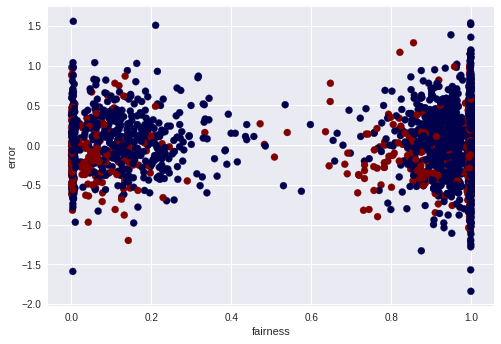

In [0]:
fairness_sex = FairnessAwareMetaEstimator(lr_sex)
fairness_sex.fit(X_sex, y_protected, s_sex)


fair_y_sex_test = fairness_sex.predict_proba(X_sex_test, s_sex_test)

fair_y_sex_test = np.array([val[1] for val in fair_y_sex_test])

error_sex_test = [(x.RecidivismScore - x.RecidivismEst) for x in test_data.itertuples()]

plt.scatter(x = fair_y_sex_test, y = error_sex_test, c = s_sex_test, cmap='seismic')
plt.xlabel('fairness')
plt.ylabel('error')

## Race

D E S C R I P T I O N ​

Below we have a graph that plots the amount of “fairness” on the x-axis and the error (actual subtracted from predicted) on the y-axis. The points are color-coded based on the the race of the criminal, with red representing people of color and blue representing Caucasian.  ​

I N T E R P R E T A T I O N

When the **fairness is low**, the predictive algorithm is more likely give the criminal a **lower recidivism score**. We were able to make this conclusion because a considerable amount of points on clustering on the left are above the y = 0 line, indicating that the majority of the errors (actual - predicted) are positive. Additionally, the majority of the points clustering here on the left are red, indicating that a sufficient amount of the Caucasian criminals are given a lower recidivism score by the prediction algorithm than they actually deserve. 

When the **fairness is high**, the predictive algorithm seems to err, giving the criminal a recidivism score that’s both too high and too low just as often. Therefore, that’s why there’s a pretty even amount of points both in the positive and negative regions on the graph. In fact, when the fairness is high, the **prediction seems to make larger errors**. 
 


Text(0,0.5,'error')

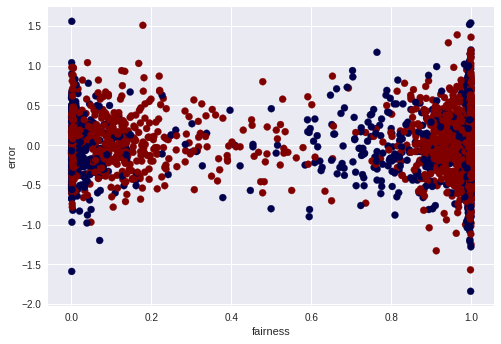

In [0]:
fairness_race = FairnessAwareMetaEstimator(lr_race)
fairness_race.fit(X_race, y_protected, s_race)


fair_y_race_test = fairness_race.predict_proba(X_race_test, s_race_test)

fair_y_race_test = np.array([val[1] for val in fair_y_race_test])

error_race_test = [(x.RecidivismScore - x.RecidivismEst) for x in test_data.itertuples()]

plt.scatter(x = fair_y_race_test, y = error_race_test, c = s_race_test, cmap='seismic')
plt.xlabel('fairness')
plt.ylabel('error')

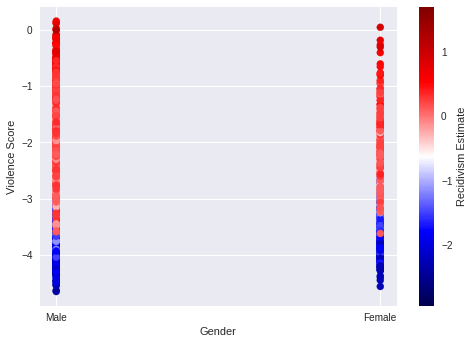

In [0]:
plt.scatter(x = test_data.Sex_Code_Text, y = test_data.ViolenceScore, c = test_data.RecidivismEst, cmap='seismic')
plt.ylabel('Violence Score')
plt.xlabel('Gender')
cbar = plt.colorbar()
cbar.set_label('Recidivism Estimate')